In [ ]:
! pip install ftfy regex tqdm
  # ! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 601 kB/s 


In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease' is no longer signed.
W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease' is no longer signed.


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf

# Source retrieval with CLIP

In [ ]:
import os
import json
import torch
# import clip
import numpy as np
import IPython.display
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm
import pickle
%pip install transformers
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
from PIL import Image
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Torch version:", torch.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')
model.to(device).eval()
# input_resolution = model.visual.input_resolution
# context_length   = model.context_length
# vocab_size       = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

# print("Context length:",   context_length)
# print("Vocab size:",       vocab_size)

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 6.6 MB 11.9 MB/s 
     |████████████████████████████████| 895 kB 6.3 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Torch version: 1.11.0+cu113


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model parameters: 108,310,272


## Load distances

In [ ]:
with open('/content/drive/MyDrive/IDL-Project/WebQA_data_first_release/WebQA_train_val.json') as f:
    json_dict = json.load(f)

json_dict[list(json_dict.keys())[0]].keys()

dict_keys(['Q', 'A', 'topic', 'split', 'Qcate', 'Guid', 'img_posFacts', 'img_negFacts', 'txt_negFacts', 'txt_posFacts'])

# Retrieval F1

In [ ]:
size_dev_set = 0

for key, value in json_dict.items():
    if json_dict[key]['split'] != 'val':
        continue
    size_dev_set += 1

In [ ]:
retrieved = 0
relevant  = 0
retrieved_and_relevant = 0
threshold = 0.77

for key, value in json_dict.items():
    if json_dict[key]['split'] != 'val':
        continue

    modality = None

    if len(json_dict[key]['img_posFacts']) > 0:
        for positive_img in json_dict[key]['img_posFacts']:
            retrieved              += positive_img['title_q_similarity'] > threshold
            retrieved_and_relevant += positive_img['title_q_similarity'] > threshold
            relevant += 1
            modality = 'img'

    elif len(json_dict[key]['txt_posFacts']) > 0:
        for positive_txt in json_dict[key]['txt_posFacts']:
            retrieved              += positive_txt['fact_q_similarity'] > threshold
            retrieved_and_relevant += positive_txt['fact_q_similarity'] > threshold
            relevant += 1
            modality = 'txt'

    if (len(json_dict[key]['img_negFacts']) > 0) :
        for negative_img in json_dict[key]['img_negFacts']:
            retrieved += negative_img['title_q_similarity'] > threshold
            
    if (len(json_dict[key]['txt_negFacts']) > 0) :
        for negative_txt in json_dict[key]['txt_negFacts']:
            retrieved += negative_txt['fact_q_similarity'] > threshold

precision = retrieved_and_relevant / retrieved
recall    = retrieved_and_relevant / relevant
f1        = 2 * (precision * recall) / (precision + recall)

print(f1)

0.15722543352601157


## Load dataset

In [ ]:
with open('/content/drive/MyDrive/IDL-Project/WebQA_data_first_release/WebQA_train_val.json') as f:
    json_dict = json.load(f)

json_dict[list(json_dict.keys())[0]].keys()

dict_keys(['Q', 'A', 'topic', 'split', 'Qcate', 'Guid', 'img_posFacts', 'img_negFacts', 'txt_negFacts', 'txt_posFacts'])

## Compute similarities

In [ ]:
distances_dict = json_dict

batch_bar = tqdm(total=size_dev_set, dynamic_ncols=True, desc='Similarities', position=0, leave=True) 

source_types = {'img_posFacts' : ['title', 'caption'],
                'img_negFacts' : ['title', 'caption'],
                'txt_negFacts' : ['title', 'fact'],
                'txt_posFacts' : ['title', 'fact']}

def encode_text(txt):
    tokens = tokenizer(txt, 
                        padding='max_length', max_length = 512, truncation=True,
                        return_tensors="pt")
    mask = tokens['attention_mask'].to(device)
    input_id = tokens['input_ids'].squeeze(1).to(device)
    _, pooled_output = model(input_ids=input_id, attention_mask=mask,return_dict=False)

    return pooled_output



with torch.no_grad():
    for i, (key, qa) in enumerate(json_dict.items()):
        # Encode question
        question          = qa['Q'][1:-2][:76]
        # question_tokens = tokenizer(question, 
        #                        padding='max_length', max_length = 512, truncation=True,
        #                         return_tensors="pt")
        
        # mask = question_tokens['attention_mask'].to(device)
        # input_id = question_tokens['input_ids'].squeeze(1).to(device)
        # _, pooled_output = model(input_ids=input_id, attention_mask=mask,return_dict=False)
        # question_tokens   = clip.tokenize([question]).to("cuda")
        
        question_features = encode_text(question).float()
        question_features /= question_features.norm(dim=-1, keepdim=True)

        # Compute similarity only for validation pairs
        if qa['split'] != 'val':
            continue

        # img_pos, img_neg, txt_pos, txt_neg
        for source_type, subkeys in source_types.items():
            if len(qa[source_type]) > 0:
                # Titles, captions/facts
                for subkey in subkeys:
                    try:
                        # text_tokens   = clip.tokenize( [txt[subkey][:70] for txt in qa[source_type]] ).to("cuda")
                        
                        text_features = encode_text([txt[subkey][:70] for txt in qa[source_type]]).float()
                        text_features /= text_features.norm(dim=-1, keepdim=True)

                        # Compute similarity
                        text_similarity = torch.matmul(question_features, text_features.T).squeeze(0)

                        for i in range(len(distances_dict[key][source_type])):
                            distances_dict[key][source_type][i][str(subkey) + '_q_similarity'] = text_similarity[i].detach().cpu().item()

                    except RuntimeError:
                        print("Oopsie")
                        for i in range(len(distances_dict[key][source_type])):
                            distances_dict[key][source_type][i][str(subkey) + '_q_similarity'] = 0         
        batch_bar.update()

batch_bar.close()

Similarities: 100%|██████████| 4966/4966 [3:28:52<00:00,  2.52s/it]


# PCA for funsies

In [ ]:
batch_bar = tqdm(total=150, dynamic_ncols=True, desc='Dev Similarities') 


source_types = {'img_posFacts' : ['title', 'caption'],
                'img_negFacts' : ['title', 'caption'],
                'txt_negFacts' : ['title', 'fact'],
                'txt_posFacts' : ['title', 'fact']}

features = []
with torch.no_grad():
    for i, (key, qa) in enumerate(json_dict.items()):
        if i >= 150:
            break
        # Encode question
        question          = qa['Q'][1:-2]
        question_tokens   = clip.tokenize([question])
        
        input_id = question_tokens['input_ids'].squeeze().cuda()
        mask = question_tokens['attention_mask'].cuda()

        question_features = model.encode_text(question_tokens).float()
        question_features /= question_features.norm(dim=-1, keepdim=True)

        features.append(question_features)
        # img_pos, img_neg, txt_pos, txt_neg
        for source_type, subkeys in source_types.items():
            if len(qa[source_type]) > 0:

                # Titles, captions/facts
                for subkey in subkeys:
                    text_tokens   = clip.tokenize( [txt[subkey][:60] for txt in qa[source_type]] )
                    text_features = model.encode_text(text_tokens)
                    text_features /= text_features.norm(dim=-1, keepdim=True)
                    features.append(text_features.detach().numpy())

        batch_bar.update()

batch_bar.close()

Dev Similarities: 100%|██████████| 150/150 [12:25<00:00,  4.97s/it]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(np.vstack(features))

#i = np.random.randint(150)

question = json_dict[list(json_dict.keys())[i]]['Q'][1:-2]
question_tokens   = clip.tokenize([question])
question_features = model.encode_text(question_tokens)
question_features /= question_features.norm(dim=-1, keepdim=True)
tquestion_features = pca.transform(question_features.detach().numpy())


text_tokens = clip.tokenize( [ a['fact'][:60]  for a in json_dict[list(json_dict.keys())[i]]['txt_negFacts'] ]) 
txtneg_features = model.encode_text(text_tokens)
txtneg_features /= txtneg_features.norm(dim=-1, keepdim=True)
txtneg_features = np.vstack(txtneg_features.detach().numpy())
ttxtneg_features = pca.transform(txtneg_features)

text_tokens = clip.tokenize([ a['title'][:60]  for a in json_dict[list(json_dict.keys())[i]]['img_negFacts'] ])
imgneg_features = model.encode_text(text_tokens)
imgneg_features /= imgneg_features.norm(dim=-1, keepdim=True)
imgneg_features = np.vstack(imgneg_features.detach().numpy())
timgneg_features = pca.transform(imgneg_features)


text_tokens = clip.tokenize([ a['title'][:60]  for a in json_dict[list(json_dict.keys())[i]]['img_posFacts'] ])
imgpos_features = model.encode_text(text_tokens)
imgpos_features /= imgpos_features.norm(dim=-1, keepdim=True)
imgpos_features = np.vstack(imgpos_features.detach().numpy())
timgpos_features = pca.transform(imgpos_features)

Text(0, 0.5, 'PC2')

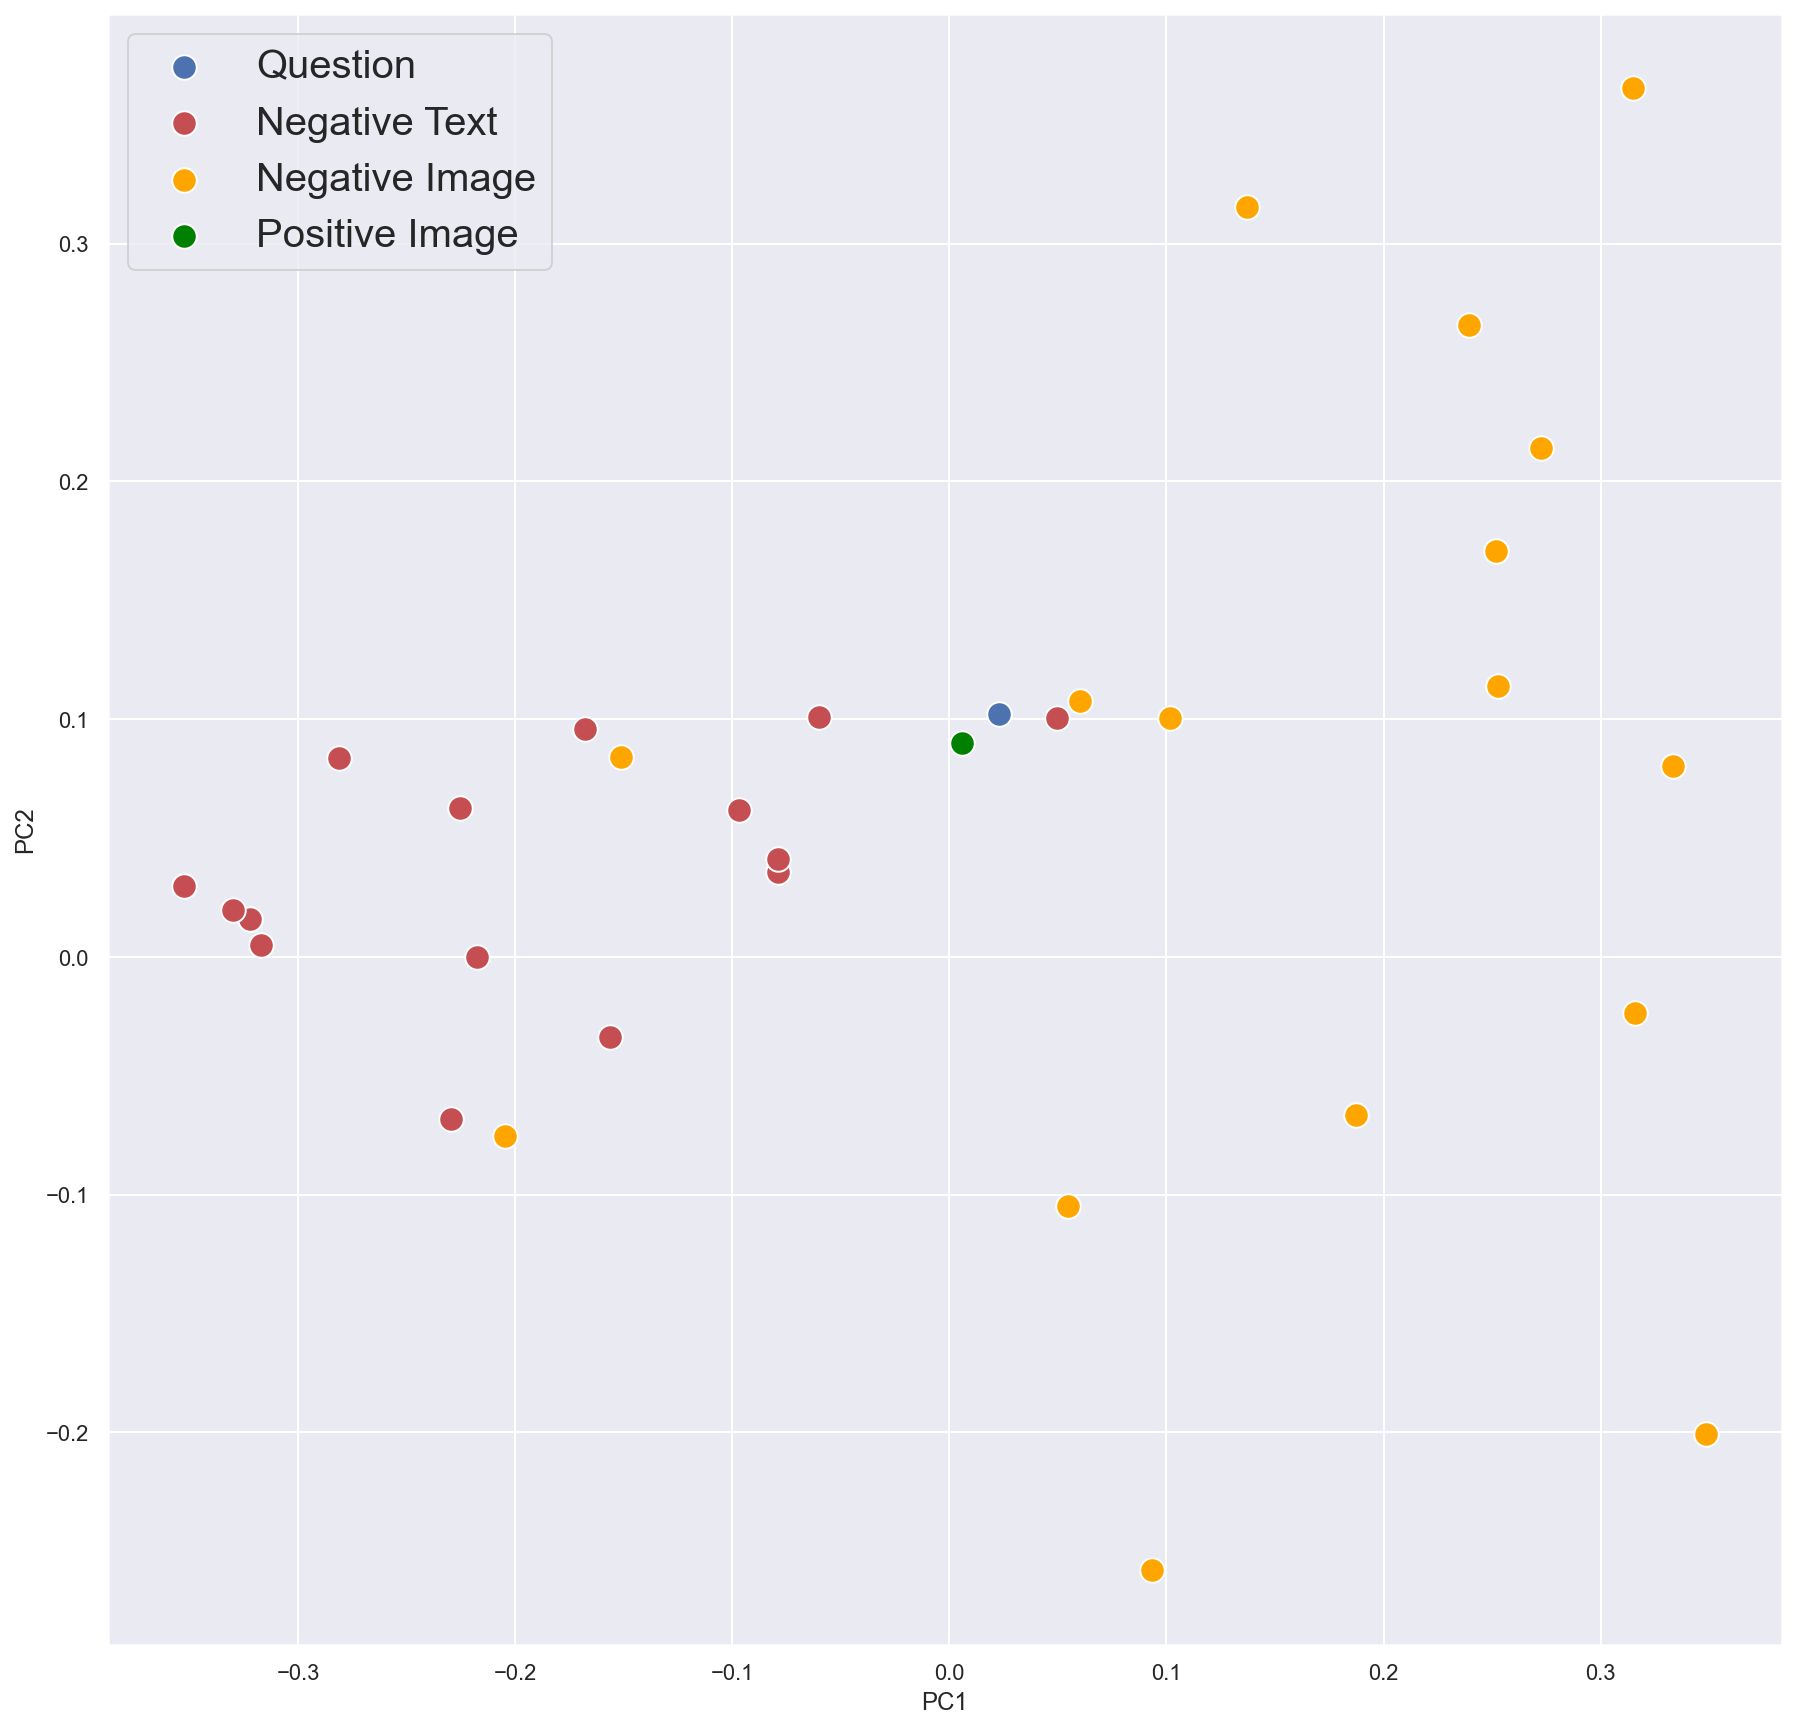

In [ ]:
plt.figure(figsize=(15,15))
sns.set(style="darkgrid")
sns.scatterplot(x=tquestion_features[:,0], y=tquestion_features[:,1], color='b', s=150)
sns.scatterplot(x=ttxtneg_features[:,0], y=ttxtneg_features[:,1], color='r', s=150)
sns.scatterplot(x=timgneg_features[:,0], y=timgneg_features[:,1], color='orange', s=150)
sns.scatterplot(x=timgpos_features[:,0], y=timgpos_features[:,1], color='green', s=150)
plt.legend(["Question", "Negative Text", "Negative Image", "Positive Image"], fontsize=20)
plt.xlabel("PC1")
plt.ylabel("PC2")